
# SCHISM procedural example

In this notebook we will use the SCHOSM grid, config and data objects to define a SCHISM workspace

In [10]:
%load_ext autoreload
%autoreload 2

# turn off warnings
import warnings
warnings.filterwarnings('ignore')

import sys
from datetime import datetime
from pathlib import Path
from rompy.core import DataBlob, TimeRange
from shutil import rmtree
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import cartopy.crs as ccrs

import logging
logging.basicConfig(level=logging.INFO)

HERE = Path('../../tests/schism')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



### Workspace basepath

In [11]:
workdir = Path("schism_procedural")
if workdir.exists():
    rmtree(workdir)

workdir.mkdir(exist_ok=True)

### Model Grid

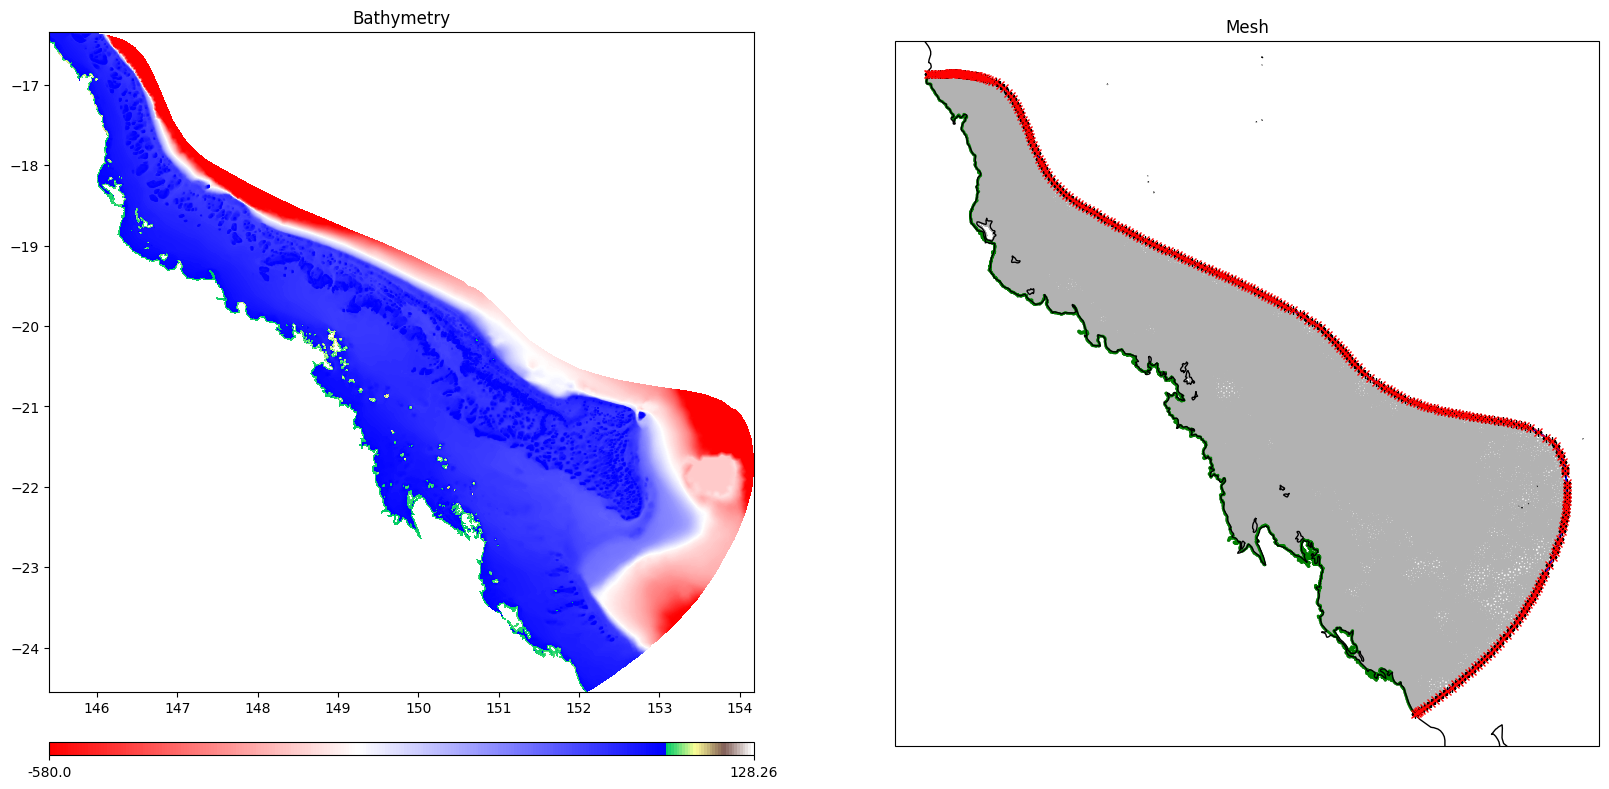

In [14]:
# Grid object

from rompy.schism import Inputs, SCHISMGrid

#SCHISMGrid?

grid=SCHISMGrid(
    hgrid=DataBlob(id="hgrid", source=HERE / "test_data" / "hgrid.gr3"),
    drag=1,
    #vgrid=DataBlob(id="vgrid", source=HERE / "test_data" / "vgrid.in"),
    #diffmin=DataBlob(id="diffmin", source=HERE / "test_data" / "diffmin.gr3"),
    #diffmax=DataBlob(id="diffmax", source=HERE / "test_data" / "diffmax.gr3"),
    #manning=DataBlob(id="manning", source=HERE / "test_data" / "manning.gr3"),
    hgrid_WWM=DataBlob(id="hgrid_WWM", source=HERE / "test_data" / "hgrid_WWM.gr3"),
    wwmbnd=DataBlob(id="wwmbnd", source=HERE / "test_data" / "wwmbnd.gr3"),
)

grid.plot_hgrid()

In [15]:
grid.get(workdir)
list(workdir.glob('*'))

INFO:rompy.schism.grid:Generated drag with constant value of 1.0
INFO:rompy.schism.grid:Generated diffmin with constant value of 1e-06
INFO:rompy.schism.grid:Generated diffmax with constant value of 1.0
INFO:rompy.schism.grid:Creating symbolic link for hgrid.ll
INFO:rompy.schism.grid:Generated albedo with constant value of 0.15
INFO:rompy.schism.grid:Generated watertype with constant value of 1.0
INFO:rompy.schism.grid:Generated windrot_geo2proj with constant value of 0.0


[PosixPath('schism_procedural/hgrid.gr3'),
 PosixPath('schism_procedural/hgrid.ll'),
 PosixPath('schism_procedural/diffmin.gr3'),
 PosixPath('schism_procedural/watertype.gr3'),
 PosixPath('schism_procedural/albedo.gr3'),
 PosixPath('schism_procedural/windrot_geo2proj.gr3'),
 PosixPath('schism_procedural/wwmbnd.gr3'),
 PosixPath('schism_procedural/tvprop.in'),
 PosixPath('schism_procedural/diffmax.gr3'),
 PosixPath('schism_procedural/drag.gr3'),
 PosixPath('schism_procedural/hgrid_WWM.gr3')]


# Forcing data

In [16]:
# First lists import the main data classes
from rompy.schism.data import SCHISMDataSflux, SCHISMDataOcean, SCHISMDataWave, SCHISMDataTides

# Sets also import a few of the minor classes that are used in the construction of these main classes for use in this demo
from rompy.schism.data import SfluxSource, TidalDataset, SfluxAir, SCHISMDataBoundary

# And also lets import some of the core data source objects. These are data input abstractions that work in exactly the same way as 
# with the swan classes, and can be used interchangeably in each of the data classes depending on the data source. We will use a 
# bit of a mix here for illustration purposes.
from rompy.core.data import DataBlob, SourceFile, SourceDataset, SourceIntake, SourceDatamesh
from rompy.core.boundary import SourceWavespectra

### Sflux Data

In [17]:
from rompy.schism.namelists import Sflux_Inputs
# SCHISMDataSflux??
# SfluxSource??
# Sflux_Inputs??



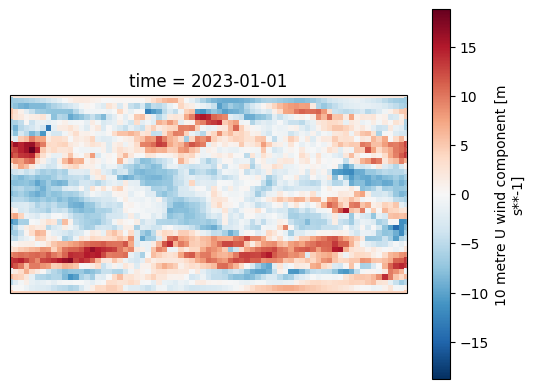

In [18]:
import intake
cat = intake.open_catalog(HERE / ".." / "data" / "catalog.yaml")
ds = cat.era5.to_dask()
ax = plt.axes(projection=ccrs.PlateCarree())
ds.u10[0].plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r")

In [19]:
# Lets have a look at an flux object. Here we will use a ERA5 dataset exposed through the intake catalog in the tests/data folder.
from rompy.core.time import TimeRange

atmos_forcing = SCHISMDataSflux(
    air_1=SfluxAir(
        id="air_1",
        source=SourceIntake(
            dataset_id="era5",
            catalog_uri=HERE / ".." / "data" / "catalog.yaml",
        ),
        filter={
            "sort": {"coords": ["latitude"]},
        },
    buffer=2
    )
)
atmos_forcing.get(destdir=workdir, grid=grid, time=TimeRange(start="2023-01-01", end="2023-01-02", dt=3600))

INFO:rompy.schism.data:Fetching air_1


In [20]:
list(workdir.glob('**/*'))



[PosixPath('schism_procedural/hgrid.gr3'),
 PosixPath('schism_procedural/hgrid.ll'),
 PosixPath('schism_procedural/diffmin.gr3'),
 PosixPath('schism_procedural/sflux_air_1.0001.nc'),
 PosixPath('schism_procedural/watertype.gr3'),
 PosixPath('schism_procedural/albedo.gr3'),
 PosixPath('schism_procedural/sflux'),
 PosixPath('schism_procedural/windrot_geo2proj.gr3'),
 PosixPath('schism_procedural/wwmbnd.gr3'),
 PosixPath('schism_procedural/tvprop.in'),
 PosixPath('schism_procedural/diffmax.gr3'),
 PosixPath('schism_procedural/drag.gr3'),
 PosixPath('schism_procedural/hgrid_WWM.gr3'),
 PosixPath('schism_procedural/sflux/sflux_inputs.txt')]

<xarray.Dataset>
Dimensions:    (latitude: 3, longitude: 3, time: 5)
Coordinates:
  * latitude   (latitude) float32 -25.0 -20.0 -15.0
  * longitude  (longitude) float32 145.0 150.0 155.0
  * time       (time) datetime64[ns] 2023-01-01 2082-02-20 ... 2259-07-23
Data variables:
    u10        (time, latitude, longitude) float64 -1.638 -2.61 ... 8.287 3.778
    v10        (time, latitude, longitude) float64 -4.745 1.322 ... 2.083 -0.777
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-10 00:03:38 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

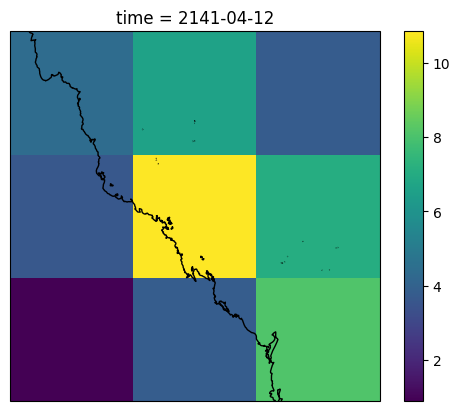

In [21]:
# Create a map
ax = plt.axes(projection=ccrs.PlateCarree())
# load the data
ds = xr.open_dataset("schism_procedural/sflux_air_1.0001.nc")
wind_speed = np.sqrt(ds.u10**2 + ds.v10**2)
# plot the data
wind_speed.isel(time=2).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ds


### Ocean Boundary

In [22]:
#SCHISMDataOcean??

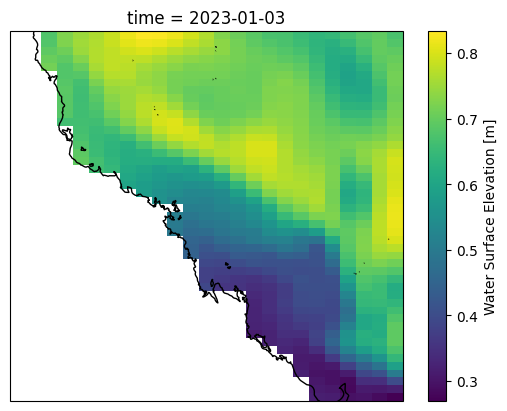

In [27]:
ds = xr.open_dataset(HERE / "test_data" / "hycom.nc")
ax = plt.axes(projection=ccrs.PlateCarree())
ds["surf_el"].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

In [28]:

ocean_forcing = SCHISMDataOcean(
                elev2D = SCHISMDataBoundary(
                    id="hycom",
                    source=SourceFile(
                        uri=HERE / "test_data" / "hycom20230101.nc",
                    ),
                    variable="surf_el",
                    coords={"t": "time", "y": "ylat", "x": "xlon", "z": "depth"},
                    )
                )



In [29]:
ocean_forcing.get(destdir=workdir, grid=grid)
list(workdir.glob("*"))



INFO:rompy.schism.data:Fetching elev2D


[PosixPath('schism_procedural/hgrid.gr3'),
 PosixPath('schism_procedural/hgrid.ll'),
 PosixPath('schism_procedural/diffmin.gr3'),
 PosixPath('schism_procedural/sflux_air_1.0001.nc'),
 PosixPath('schism_procedural/watertype.gr3'),
 PosixPath('schism_procedural/albedo.gr3'),
 PosixPath('schism_procedural/sflux'),
 PosixPath('schism_procedural/windrot_geo2proj.gr3'),
 PosixPath('schism_procedural/wwmbnd.gr3'),
 PosixPath('schism_procedural/tvprop.in'),
 PosixPath('schism_procedural/diffmax.gr3'),
 PosixPath('schism_procedural/elev2D.th.nc'),
 PosixPath('schism_procedural/drag.gr3'),
 PosixPath('schism_procedural/hgrid_WWM.gr3')]

In [30]:
ds = xr.open_dataset('schism_procedural/elev2D.th.nc')
ds

<xarray.Dataset>
Dimensions:        (one: 1, time: 3, nOpenBndNodes: 286, nLevels: 1,
                    nComponents: 1)
Coordinates:
  * time           (time) float64 0.0 8.64e+04 1.728e+05
  * nOpenBndNodes  (nOpenBndNodes) int64 0 1 2 3 4 5 ... 280 281 282 283 284 285
  * nComponents    (nComponents) int64 1
  * one            (one) int64 1
Dimensions without coordinates: nLevels
Data variables:
    time_step      (one) float64 ...
    time_series    (time, nOpenBndNodes, nLevels, nComponents) float32 ...

### Wave

In [31]:
# SCHISMDataWave??

In [32]:
wave_forcing = SCHISMDataWave(
        id="wavedata",
        source=SourceIntake(
            dataset_id="ausspec",
            catalog_uri=HERE / ".." / "data" / "catalog.yaml",
        ),
        sel_method="nearest",
        coords={'x': "lon", 'y': "lat"},
)


<GeoAxes: >

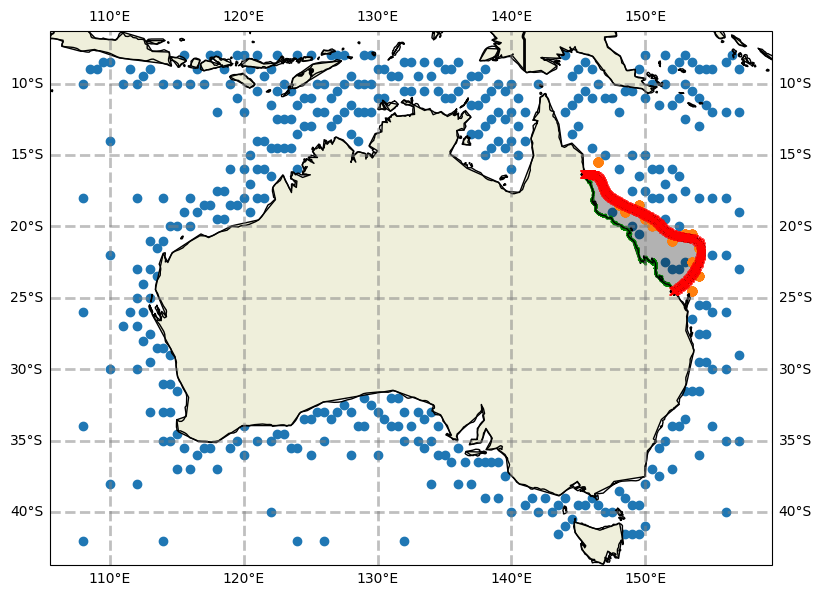

In [33]:
ax = wave_forcing.plot(model_grid=grid)
wave_forcing.plot_boundary(ax=ax, grid=grid)

### Tidal data

In [34]:
# SCHISMDataTides?
# TidalDataset?

In [39]:
tidal_forcing = SCHISMDataTides(
    tidal_data=TidalDataset(
        elevations=HERE / "test_data"/ "tpxo9-test" / "h_m2s2n2.nc",
        velocities=HERE / "test_data"/ "tpxo9-test" / "u_m2s2n2.nc" 
    ),
    constituents=["M2", "S2", "N2"],
)
tidal_forcing.get(
    destdir=workdir,
    grid=grid,
    time=TimeRange(start="2023-01-01", end="2023-01-02", dt=3600),
)



INFO:rompy.schism.data:Generating tides
INFO:pyschism.forcing.bctides.bctides:Processing boundary 1:
INFO:pyschism.forcing.bctides.bctides:Elevation type: 5
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for elevation constituent M2.
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for elevation constituent S2.
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for elevation constituent N2.
INFO:pyschism.forcing.bctides.bctides:Velocity type: 5
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for velocity constituent M2.
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for velocity constituent S2.
INFO:pyschism.forcing.bctides.tpxo:Querying TPXO for velocity constituent N2.
INFO:pyschism.forcing.bctides.bctides:Temperature type: 4
INFO:pyschism.forcing.bctides.bctides:Nudging factor for T at boundary 1 is1
INFO:pyschism.forcing.bctides.bctides:Salinity type: 4
INFO:pyschism.forcing.bctides.bctides:Nudging factor for salt at boundary 1 is 1


# Full config object

In [40]:

# Instantiate a config object

from rompy.schism import SchismCSIROConfig
from rompy.schism.data import SCHISMData
from pydantic import ValidationError
try:
    config=SchismCSIROConfig(
        grid=grid,
        data=SCHISMData(
            atmos=atmos_forcing, 
            ocean=ocean_forcing, 
            wave=wave_forcing, 
            tides=tidal_forcing
            ),
    )
except ValidationError as e:
    print(e)

1 validation error for SchismCSIROConfig
  Value error, manning.gr3 must be specified when nchi=-1 [type=value_error, input_value={'grid': SCHISMGrid([146....], sobc=[1], relax=[]))}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.4/v/value_error


In [42]:
# That gives us an expected error due to teh fact that we have a validator checking required inputs
# Lets fix the grid issue and try again

try:
    config=SchismCSIROConfig(
        grid=grid,
        data=SCHISMData(
            atmos=atmos_forcing, 
            ocean=ocean_forcing, 
            wave=wave_forcing, 
            tides=tidal_forcing
            ),
    )
except ValidationError as e:
    print(e)


# Again we get a validation error, the hgrid_WWM is missing. Lets add it and try again

grid=SCHISMGrid(
    hgrid=DataBlob(id="hgrid", source=HERE / "test_data" / "hgrid.gr3"),
    manning=DataBlob(id="manning", source=HERE / "test_data" / "manning.gr3"),
    wwmbnd=DataBlob(id="wwmbnd", source=HERE / "test_data" / "wwmbnd.gr3"),
    hgrid_WWM=DataBlob(id="hgrid_WWM", source=HERE / "test_data" / "hgrid_WWM.gr3"),
)
config=SchismCSIROConfig(
    grid=grid,
    data=SCHISMData(
        atmos=atmos_forcing, 
        ocean=ocean_forcing, 
        wave=wave_forcing, 
        tides=tidal_forcing
        ),
)


1 validation error for SchismCSIROConfig
  Value error, hgrid_WWM.gr3 must be specified for csiro template [type=value_error, input_value={'grid': SCHISMGrid([146....], sobc=[1], relax=[]))}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.4/v/value_error


In [43]:
# config.model_dump()

In [44]:
config.data

SCHISMData(data_type='schism', atmos=SCHISMDataSflux(data_type='sflux', air_1=SfluxAir(model_type='data_grid', id='air_1', source=SourceIntake(model_type='intake', dataset_id='era5', catalog_uri=PosixPath('../../tests/schism/../data/catalog.yaml'), kwargs={}), filter=Filter(sort={'coords': ['latitude']}, subset={}, crop={'longitude': Slice(start=143.406058, stop=156.171625), 'latitude': Slice(start=-26.553174, stop=-14.338505000000001), 'time': Slice(start=datetime.datetime(2023, 1, 1, 0, 0), stop=datetime.datetime(2023, 1, 2, 0, 0))}, timenorm={}, rename={}, derived={}), variables=[], coords=DatasetCoords(t='time', x='longitude', y='latitude', z='depth'), crop_data=True, buffer=2.0, data_type='sflux_air', relative_weight=1.0, max_window_hours=120.0, fail_if_missing=True, uwind_name=None, vwind_name=None, prmsl_name=None, stmp_name=None, spfh_name=None), air_2=None, rad_1=None, rad_2=None, prc_1=None, prc_2=None), ocean=SCHISMDataOcean(data_type='ocean', elev2D=SCHISMDataBoundary(model

# Model Run

Note  that most fields are optional, this eample using defaults values.


### Generate workspace


In [45]:
if workdir.exists():
    rmtree(workdir)

workdir.mkdir(exist_ok=True)

from rompy.model import ModelRun
from rompy.schism import SchismCSIROConfig

run = ModelRun(
    run_id="test_schism",
    period=TimeRange(start=datetime(2023, 1, 1, 0), end=datetime(2023, 1, 2, 0), interval="1h"),
    output_dir=str(workdir),
    config=config
)

rundir = run()


INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
run_id: test_schism
period: 
	Start: 2023-01-01 00:00:00
	End: 2023-01-02 00:00:00
	Duration: 1 day, 0:00:00
	Interval: 1:00:00
	Include End: True

output_dir: schism_procedural
config: <class 'rompy.schism.config.SchismCSIROConfig'>

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in schism_procedural
INFO:rompy.schism.grid:Generated diffmin with constant value of 1e-06
INFO:rompy.schism.grid:Generated diffmax with constant value of 1.0
INFO:rompy.schism.grid:Creating symbolic link for hgrid.ll
INFO:rompy.schism.grid:Generated albedo with constant value of 0.15
INFO:rompy.schism.grid:Generated watertype with constant value of 1.0
INFO:rompy.schism.grid:Generated windrot_geo2proj with constant value of 0.0
INFO:rompy.schism.data:Fetching air_1
INFO:rompy.schism.data:Fetching elev2

In [46]:
import yaml
# dump full model to yaml
with open('model.yaml', 'w') as f:
    yaml.dump(run.model_dump(), f)


In [47]:
!cat model.yaml

config:
  CGPP: F
  CPP: F
  DM: T
  DPEAK: T
  DSPR: T
  HS: T
  KPP: F
  LPP: F
  ORBITAL: F
  PEAKD: T
  PEAKDSPR: T
  TM01: T
  TM02: F
  TPP: T
  TPPD: T
  UBOT: F
  WNPP: F
  ac: T
  brcrYN: ''
  checkout: main
  currYN: '!'
  data:
    atmos:
      air_1:
        buffer: 2.0
        coords:
          t: time
          x: longitude
          y: latitude
          z: depth
        crop_data: true
        data_type: sflux_air
        fail_if_missing: true
        filter:
          crop:
            latitude:
              start: !!python/object/apply:numpy.core.multiarray.scalar
              - &id001 !!python/object/apply:numpy.dtype
                args:
                - f8
                - false
                - true
                state: !!python/tuple
                - 3
                - <
                - null
                - null
                - null
                - -1
                - -1
                - 0
              - !!binary |
                XP+uz5yNOsA

### Check the workspace

In [48]:
list(Path(rundir).glob("*"))

[PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/bctides.in'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/hgrid.gr3'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/datasets'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/README'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/hgrid.ll'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/wwminput.nml'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/diffmin.gr3'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/sflux_air_1.0001.nc'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/watertype.gr3'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/albedo.gr3'),
 PosixPath('/source/rompy/notebooks/schism/schism_procedural/test_schism/sflux'),
 PosixPath('/source/rompy/notebooks/schism

In [49]:
!cat demo.yaml

output_dir: schism_declaritive
period:
  start: 20230101T00
  end: 20230102T00
  interval: 3600
run_id: test_schism
config:
  model_type: schismcsiro
  grid:
    grid_type: schism
    hgrid:
      id: hgrid
      model_type: data_blob
      source: ../../tests/schism/test_data/hgrid.gr3
    manning:
      model_type: data_blob
      source: ../../tests/schism/test_data/manning.gr3
    hgrid_WWM:
      model_type: data_blob
      source: ../../tests/schism/test_data/hgrid_WWM.gr3
    wwmbnd:
      model_type: data_blob
      source: ../../tests/schism/test_data/wwmbnd.gr3
  data:
    data_type: schism
    atmos:
      air_1:
        buffer: 0.0
        id: era5
        source: 
          uri:  ../../tests/data/era5-20230101.nc
          model_type: open_dataset
          filter:
            sort: {coords: [latitude]}
        variables: 
          - u10
          - v10
    ocean:
      elev2D:
        buffer: 0.0
        coords:
          t: time
          x: xlon
          y: ylat
     

In [50]:
demo_config = yaml.load(open('demo.yaml', 'r'), Loader=yaml.FullLoader)

In [51]:
run = ModelRun(**demo_config)